In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Creamos una carpeta específica para tus modelos
import os
save_path = "/content/drive/MyDrive/IA_Modelos_Entrenados"
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"✅ Carpeta creada en Drive: {save_path}")

Mounted at /content/drive
✅ Carpeta creada en Drive: /content/drive/MyDrive/IA_Modelos_Entrenados


To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your local device, follow [our guide](https://unsloth.ai/docs/get-started/install). This notebook is licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & how to save it

### News

Train MoEs - DeepSeek, GLM, Qwen and gpt-oss 12x faster with 35% less VRAM. [Blog](https://unsloth.ai/docs/new/faster-moe)

You can now train embedding models 1.8-3.3x faster with 20% less VRAM. [Blog](https://unsloth.ai/docs/new/embedding-finetuning)

Ultra Long-Context Reinforcement Learning is here with 7x more context windows! [Blog](https://unsloth.ai/docs/new/grpo-long-context)

3x faster LLM training with 30% less VRAM and 500K context. [3x faster](https://unsloth.ai/docs/new/3x-faster-training-packing) • [500K Context](https://unsloth.ai/docs/new/500k-context-length-fine-tuning)

New in Reinforcement Learning: [FP8 RL](https://unsloth.ai/docs/new/fp8-reinforcement-learning) • [Vision RL](https://unsloth.ai/docs/new/vision-reinforcement-learning-vlm-rl) • [Standby](https://unsloth.ai/docs/basics/memory-efficient-rl) • [gpt-oss RL](https://unsloth.ai/docs/new/gpt-oss-reinforcement-learning)

Visit our docs for all our [model uploads](https://unsloth.ai/docs/get-started/unsloth-model-catalog) and [notebooks](https://unsloth.ai/docs/get-started/unsloth-notebooks).

### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth  # Do this in local & cloud setups
else:
    import torch; v = re.match(r'[\d]{1,}\.[\d]{1,}', str(torch.__version__)).group(0)
    xformers = 'xformers==' + {'2.10':'0.0.34','2.9':'0.0.33.post1','2.8':'0.0.32.post2'}.get(v, "0.0.34")
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth_zoo bitsandbytes accelerate {xformers} peft trl triton unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer
!pip install einops addict easydict

### Unsloth

Let's prepare the OCR model to our local first

In [4]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

'/content/deepseek_ocr'

In [6]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Qwen3-VL-8B-Instruct-bnb-4bit", # Qwen 3 vision support
    "unsloth/Qwen3-VL-8B-Thinking-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Instruct-bnb-4bit",
    "unsloth/Qwen3-VL-32B-Thinking-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
    auto_model = AutoModel,
    trust_remote_code = True,
    unsloth_force_compile = True,
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2026.2.1: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at ./deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Let's Evaluate Deepseek-OCR Baseline Performance on Persian Transcription

In [8]:
from datasets import load_dataset
dataset = load_dataset("hezarai/parsynth-ocr-200k", split = "train[:2000]")

README.md:   0%|          | 0.00/967 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/57.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/179999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [9]:
# Save an image that will not be used during training for evaluation purposes
dataset[1523]['image_path'].save("your_image.jpg")

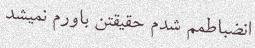

In [10]:
dataset[1523]['image_path']

In [11]:
# prompt = "<image>\nFree OCR. "
prompt = "<image>\nFree OCR. "
image_file = 'your_image.jpg'
output_path = 'your/output/dir'
# infer(self, tokenizer, prompt = '', image_file = '', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt = prompt, image_file = image_file, output_path = output_path, base_size = 1024, image_size = 640, crop_mode = True, save_results = True, test_compress = False)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


انضباطم نندم حقيقتن باورم نميتند
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


In [12]:
dataset[1523]["text"]

'انضباطمم شدم حقیقتن باورم نمیشد'

<h3>Baseline Model Performance: 23% Character Error Rate (CER) for this sample !</h3>

# Let's finetune Deepseek-OCR !

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [13]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules = [
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Detected MoE model with num_experts = 64 and target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']. Enabling LoRA on MoE parameters: ['mlp.experts.gate_up_proj', 'mlp.experts.down_proj']
Unsloth: PEFT set target_parameters but found no matching parameters.
This is expected for MoE models - Unsloth handles MoE expert LoRA targeting separately.
Unsloth: Making `model.base_model.model.model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a dataset for Persian OCR. The goal is to convert these images into a computer readable form - ie text. This can be very useful for digitizing Persian text.

You can access the dataset [here](https://huggingface.co/datasets/hezarai/parsynth-ocr-200k).

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "<|User|>",
  "content": "",
  "images": []
},
{ "role": "<|Assistant|>",
  "content": ""
},
]
```

In [14]:
instruction = "<image>\nFree OCR. "

def convert_to_conversation(sample):
    """Convert dataset sample to conversation format"""
    conversation = [
        {
            "role": "<|User|>",
            "content": instruction,
            "images": [sample['image']]
        },
        {
            "role": "<|Assistant|>",
            "content": sample["text"]
        },
    ]
    return {"messages": conversation}

# Load dataset
dataset = load_dataset("hezarai/parsynth-ocr-200k", split = "train[:1000]")
dataset = dataset.rename_column("image_path", "image")

Let's convert the dataset into the "correct" format for finetuning:

In [15]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

We look at how the conversations are structured for the first example:

In [16]:
converted_dataset[0]

{'messages': [{'role': '<|User|>',
   'content': '<image>\nFree OCR. ',
   'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=218x48>]},
  {'role': '<|Assistant|>', 'content': 'همهاش جبره و اختیار توهمه'}]}

In [17]:
# @title Create datacollator

import torch
import math
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
import io

from deepseek_ocr.modeling_deepseekocr import (
    format_messages,
    text_encode,
    BasicImageTransform,
    dynamic_preprocess,
)

@dataclass
class DeepSeekOCRDataCollator:
    """
    Args:
        tokenizer: Tokenizer
        model: Model
        image_size: Size for image patches (default: 640)
        base_size: Size for global view (default: 1024)
        crop_mode: Whether to use dynamic cropping for large images
        train_on_responses_only: If True, only train on assistant responses (mask user prompts)
    """
    tokenizer: Any
    model: Any
    image_size: int = 640
    base_size: int = 1024
    crop_mode: bool = True
    image_token_id: int = 128815
    train_on_responses_only: bool = True

    def __init__(
        self,
        tokenizer,
        model,
        image_size: int = 640,
        base_size: int = 1024,
        crop_mode: bool = True,
        train_on_responses_only: bool = True,
    ):
        self.tokenizer = tokenizer
        self.model = model
        self.image_size = image_size
        self.base_size = base_size
        self.crop_mode = crop_mode
        self.image_token_id = 128815
        self.dtype = model.dtype  # Get dtype from model
        self.train_on_responses_only = train_on_responses_only

        self.image_transform = BasicImageTransform(
            mean = (0.5, 0.5, 0.5),
            std = (0.5, 0.5, 0.5),
            normalize = True
        )
        self.patch_size = 16
        self.downsample_ratio = 4

        # Get BOS token ID from tokenizer
        if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id is not None:
            self.bos_id = tokenizer.bos_token_id
        else:
            self.bos_id = 0
            print(f"Warning: tokenizer has no bos_token_id, using default: {self.bos_id}")

    def deserialize_image(self, image_data) -> Image.Image:
        """Convert image data (bytes dict or PIL Image) to PIL Image in RGB mode"""
        if isinstance(image_data, Image.Image):
            return image_data.convert("RGB")
        elif isinstance(image_data, dict) and 'bytes' in image_data:
            image_bytes = image_data['bytes']
            image = Image.open(io.BytesIO(image_bytes))
            return image.convert("RGB")
        else:
            raise ValueError(f"Unsupported image format: {type(image_data)}")

    def calculate_image_token_count(self, image: Image.Image, crop_ratio: Tuple[int, int]) -> int:
        """Calculate the number of tokens this image will generate"""
        num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
        num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

        width_crop_num, height_crop_num = crop_ratio

        if self.crop_mode:
            img_tokens = num_queries_base * num_queries_base + 1
            if width_crop_num > 1 or height_crop_num > 1:
                img_tokens += (num_queries * width_crop_num + 1) * (num_queries * height_crop_num)
        else:
            img_tokens = num_queries * num_queries + 1

        return img_tokens

    def process_image(self, image: Image.Image) -> Tuple[List, List, List, List, Tuple[int, int]]:
        """
        Process a single image based on crop_mode and size thresholds

        Returns:
            Tuple of (images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio)
        """
        images_list = []
        images_crop_list = []
        images_spatial_crop = []

        if self.crop_mode:
            # Determine crop ratio based on image size
            if image.size[0] <= 640 and image.size[1] <= 640:
                crop_ratio = (1, 1)
                images_crop_raw = []
            else:
                images_crop_raw, crop_ratio = dynamic_preprocess(
                    image, min_num = 2, max_num = 9,
                    image_size = self.image_size, use_thumbnail = False
                )

            # Process global view with padding
            global_view = ImageOps.pad(
                image, (self.base_size, self.base_size),
                color = tuple(int(x * 255) for x in self.image_transform.mean)
            )
            images_list.append(self.image_transform(global_view).to(self.dtype))

            width_crop_num, height_crop_num = crop_ratio
            images_spatial_crop.append([width_crop_num, height_crop_num])

            # Process local views (crops) if applicable
            if width_crop_num > 1 or height_crop_num > 1:
                for crop_img in images_crop_raw:
                    images_crop_list.append(
                        self.image_transform(crop_img).to(self.dtype)
                    )

            # Calculate image tokens
            num_queries = math.ceil((self.image_size // self.patch_size) / self.downsample_ratio)
            num_queries_base = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)

            tokenized_image = ([self.image_token_id] * num_queries_base + [self.image_token_id]) * num_queries_base
            tokenized_image += [self.image_token_id]

            if width_crop_num > 1 or height_crop_num > 1:
                tokenized_image += ([self.image_token_id] * (num_queries * width_crop_num) + [self.image_token_id]) * (
                    num_queries * height_crop_num)

        else:  # crop_mode = False
            crop_ratio = (1, 1)
            images_spatial_crop.append([1, 1])

            # For smaller base sizes, resize; for larger, pad
            if self.base_size <= 640:
                resized_image = image.resize((self.base_size, self.base_size), Image.LANCZOS)
                images_list.append(self.image_transform(resized_image).to(self.dtype))
            else:
                global_view = ImageOps.pad(
                    image, (self.base_size, self.base_size),
                    color = tuple(int(x * 255) for x in self.image_transform.mean)
                )
                images_list.append(self.image_transform(global_view).to(self.dtype))

            num_queries = math.ceil((self.base_size // self.patch_size) / self.downsample_ratio)
            tokenized_image = ([self.image_token_id] * num_queries + [self.image_token_id]) * num_queries
            tokenized_image += [self.image_token_id]

        return images_list, images_crop_list, images_spatial_crop, tokenized_image, crop_ratio

    def process_single_sample(self, messages: List[Dict]) -> Dict[str, Any]:
            """
            Process a single conversation into model inputs.
            """

            # --- 1. Setup ---
            images = []
            for message in messages:
                if "images" in message and message["images"]:
                    for img_data in message["images"]:
                        if img_data is not None:
                            pil_image = self.deserialize_image(img_data)
                            images.append(pil_image)

            if not images:
                raise ValueError("No images found in sample. Please ensure all samples contain images.")

            tokenized_str = []
            images_seq_mask = []
            images_list, images_crop_list, images_spatial_crop = [], [], []

            prompt_token_count = -1 # Index to start training
            assistant_started = False
            image_idx = 0

            # Add BOS token at the very beginning
            tokenized_str.append(self.bos_id)
            images_seq_mask.append(False)

            for message in messages:
                role = message["role"]
                content = message["content"]

                # Check if this is the assistant's turn
                if role == "<|Assistant|>":
                    if not assistant_started:
                        # This is the split point. All tokens added *so far*
                        # are part of the prompt.
                        prompt_token_count = len(tokenized_str)
                        assistant_started = True

                    # Append the EOS token string to the *end* of assistant content
                    content = f"{content.strip()} {self.tokenizer.eos_token}"

                # Split this message's content by the image token
                text_splits = content.split('<image>')

                for i, text_sep in enumerate(text_splits):
                    # Tokenize the text part
                    tokenized_sep = text_encode(self.tokenizer, text_sep, bos = False, eos = False)
                    tokenized_str.extend(tokenized_sep)
                    images_seq_mask.extend([False] * len(tokenized_sep))

                    # If this text is followed by an <image> tag
                    if i < len(text_splits) - 1:
                        if image_idx >= len(images):
                            raise ValueError(
                                f"Data mismatch: Found '<image>' token but no corresponding image."
                            )

                        # Process the image
                        image = images[image_idx]
                        img_list, crop_list, spatial_crop, tok_img, _ = self.process_image(image)

                        images_list.extend(img_list)
                        images_crop_list.extend(crop_list)
                        images_spatial_crop.extend(spatial_crop)

                        # Add image placeholder tokens
                        tokenized_str.extend(tok_img)
                        images_seq_mask.extend([True] * len(tok_img))

                        image_idx += 1 # Move to the next image

            # --- 3. Validation and Final Prep ---
            if image_idx != len(images):
                raise ValueError(
                    f"Data mismatch: Found {len(images)} images but only {image_idx} '<image>' tokens were used."
                )

            # If we never found an assistant message, we're in a weird state
            # (e.g., user-only prompt). We mask everything.
            if not assistant_started:
                print("Warning: No assistant message found in sample. Masking all tokens.")
                prompt_token_count = len(tokenized_str)

            # Prepare image tensors
            images_ori = torch.stack(images_list, dim = 0)
            images_spatial_crop_tensor = torch.tensor(images_spatial_crop, dtype = torch.long)

            if images_crop_list:
                images_crop = torch.stack(images_crop_list, dim = 0)
            else:
                images_crop = torch.zeros((1, 3, self.base_size, self.base_size), dtype = self.dtype)

            return {
                "input_ids": torch.tensor(tokenized_str, dtype = torch.long),
                "images_seq_mask": torch.tensor(images_seq_mask, dtype = torch.bool),
                "images_ori": images_ori,
                "images_crop": images_crop,
                "images_spatial_crop": images_spatial_crop_tensor,
                "prompt_token_count": prompt_token_count, # This is now accurate
            }

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Collate batch of samples"""
        batch_data = []

        # Process each sample
        for feature in features:
            try:
                processed = self.process_single_sample(feature['messages'])
                batch_data.append(processed)
            except Exception as e:
                print(f"Error processing sample: {e}")
                continue

        if not batch_data:
            raise ValueError("No valid samples in batch")

        # Extract lists
        input_ids_list = [item['input_ids'] for item in batch_data]
        images_seq_mask_list = [item['images_seq_mask'] for item in batch_data]
        prompt_token_counts = [item['prompt_token_count'] for item in batch_data]

        # Pad sequences
        input_ids = pad_sequence(input_ids_list, batch_first = True, padding_value = self.tokenizer.pad_token_id)
        images_seq_mask = pad_sequence(images_seq_mask_list, batch_first = True, padding_value = False)

        # Create labels
        labels = input_ids.clone()

        # Mask padding tokens
        labels[labels == self.tokenizer.pad_token_id] = -100

        # Mask image tokens (model shouldn't predict these)
        labels[images_seq_mask] = -100

        # Mask user prompt tokens when train_on_responses_only = True (only train on assistant responses)
        if self.train_on_responses_only:
            for idx, prompt_count in enumerate(prompt_token_counts):
                if prompt_count > 0:
                    labels[idx, :prompt_count] = -100

        # Create attention mask
        attention_mask = (input_ids != self.tokenizer.pad_token_id).long()

        # Prepare images batch (list of tuples)
        images_batch = []
        for item in batch_data:
            images_batch.append((item['images_crop'], item['images_ori']))

        # Stack spatial crop info
        images_spatial_crop = torch.cat([item['images_spatial_crop'] for item in batch_data], dim = 0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "images": images_batch,
            "images_seq_mask": images_seq_mask,
            "images_spatial_crop": images_spatial_crop,
        }

<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support `DPOTrainer` and `GRPOTrainer` for reinforcement learning!!

We use our new `DeepSeekOCRDataCollator` which will help in our vision finetuning setup.

In [18]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported
FastVisionModel.for_training(model) # Enable for training!
data_collator = DeepSeekOCRDataCollator(
    tokenizer = tokenizer,
    model = model,
    image_size = 640,
    base_size = 1024,
    crop_mode = True,
    train_on_responses_only = True,
)
trainer = Trainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = data_collator, # Must use!
    train_dataset = converted_dataset,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        fp16 = not is_bf16_supported(),  # Use fp16 if bf16 is not supported
        bf16 = is_bf16_supported(),  # Use bf16 if supported
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases
        dataloader_num_workers = 2,
        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
    ),
)

/tmp/ipython-input-1030/3186188775.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.563 GB.
6.732 GB of memory reserved.


In [20]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss
1,4.062900
2,2.653300
3,3.428300
4,3.515900
5,1.962000
6,3.917900
7,2.117100
8,1.886700
9,3.058100
10,3.022800


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([9, 100, 1280])
Unsloth: Will smartly offload gradients to save VRAM!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [21]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

814.4863 seconds used for training.
13.57 minutes used for training.
Peak reserved memory = 11.496 GB.
Peak reserved memory for training = 4.764 GB.
Peak reserved memory % of max memory = 78.94 %.
Peak reserved memory for training % of max memory = 32.713 %.


<a name="Inference"></a>
### Inference
Let's run the model!

In [22]:
prompt = "<image>\nFree OCR. "
image_file = 'your_image.jpg'
output_path = 'your/output/dir'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt = prompt, image_file = image_file,
    output_path = output_path,
    image_size = 640,
    base_size = 1024,
    crop_mode = True,
    save_results = True,
    test_compress = False)

انضباطم نشدم حقیقتن باورم نمیشد
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


With only 60 steps, we dramatically improved the transcription quality. The Character Error Rate (CER) on this single sample dropped from 23% to 6%, a 74% relative reduction!

| Type | OCR |
| :--- | :--- |
| **Baseline (Pre-Finetune)** | `انضباطم نندم حقيقتن باورم نميتند` |
| **Finetuned (60 steps)** | `انضباطم نشدم حقیقتن باورم نمیشد` |
| **Ground Truth** | `انضباطمم شدم حقیقتن باورم نمیشد` |

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Hugging Face's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [23]:
model.save_pretrained("deepseek_ocr_lora")  # Local saving
tokenizer.save_pretrained("deepseek_ocr_lora")
# model.push_to_hub("your_name/deepseek_ocr_lora", token = "YOUR_HF_TOKEN") # Online saving
# tokenizer.push_to_hub("your_name/deepseek_ocr_lora", token = "YOUR_HF_TOKEN") # Online saving

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


('deepseek_ocr_lora/tokenizer_config.json',
 'deepseek_ocr_lora/special_tokens_map.json',
 'deepseek_ocr_lora/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [24]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "deepseek_ocr_lora", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = False, # Use 4bit to reduce memory use. False for 16bit LoRA.
        auto_model = AutoModel,
        trust_remote_code = True,
        unsloth_force_compile = True,
        use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
    )
    FastVisionModel.for_inference(model) # Enable for inference!

prompt = "<image>\nFree OCR. "
image_file = 'your_image.jpg'
output_path = 'your/output/dir'

# Tiny: base_size = 512, image_size = 512, crop_mode = False
# Small: base_size = 640, image_size = 640, crop_mode = False
# Base: base_size = 1024, image_size = 1024, crop_mode = False
# Large: base_size = 1280, image_size = 1280, crop_mode = False

# Gundam: base_size = 1024, image_size = 640, crop_mode = True

res = model.infer(tokenizer, prompt = prompt, image_file = image_file,
    output_path = output_path,
    image_size = 640,
    base_size = 1024,
    crop_mode = True,
    save_results = True,
    test_compress = False)

انضباطم نشدم حقیقتن باورم نمیشد
===============save results:===============


image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens. See [our docs](https://unsloth.ai/docs/basics/inference-and-deployment) for more deployment options.

In [25]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "YOUR_HF_TOKEN")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/unsloth) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other resources:
1. Looking to use Unsloth locally? Read our [Installation Guide](https://unsloth.ai/docs/get-started/install) for details on installing Unsloth on Windows, Docker, AMD, Intel GPUs.
2. Learn how to do Reinforcement Learning with our [RL Guide and notebooks](https://unsloth.ai/docs/get-started/reinforcement-learning-rl-guide).
3. Read our guides and notebooks for [Text-to-speech (TTS)](https://unsloth.ai/docs/basics/text-to-speech-tts-fine-tuning) and [vision](https://unsloth.ai/docs/basics/vision-fine-tuning) model support.
4. Explore our [LLM Tutorials Directory](https://unsloth.ai/docs/models/tutorials-how-to-fine-tune-and-run-llms) to find dedicated guides for each model.
5. Need help with Inference? Read our [Inference & Deployment page](https://unsloth.ai/docs/basics/inference-and-deployment) for details on using vLLM, llama.cpp, Ollama etc.

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://unsloth.ai/docs/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️

  This notebook and all Unsloth notebooks are licensed [LGPL-3.0](https://github.com/unslothai/notebooks?tab=LGPL-3.0-1-ov-file#readme)
</div>

In [ ]:
model.save_pretrained_gguf(
    "/content/drive/MyDrive/IA_Modelos_Entrenados/mi_modelo_qwen",
    tokenizer,
    quantization_method = "q4_k_m" # Este es el ideal para tu RTX 3060
)

Unsloth: Merging model weights to 16-bit format...
Detected local model directory: /content/deepseek_ocr
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub


Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [02:47<00:00, 167.66s/it]


Copied model-00001-of-000001.safetensors from local model directory


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [04:28<00:00, 268.52s/it]


Unsloth: Merge process complete. Saved to `/content/drive/MyDrive/IA_Modelos_Entrenados/mi_modelo_qwen`
Unsloth: Converting to GGUF format...
==((====))==  Unsloth: Conversion from HF to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF f16 might take 3 minutes.
\        /    [2] Converting GGUF f16 to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: Updating system package directories
Unsloth: All required system packages already installed!
Unsloth: Install llama.cpp and building - please wait 1 to 3 minutes
Unsloth: Cloning llama.cpp repository
Unsloth: Install GGUF and other packages
